In [1]:
from jax import jit, random
import pandas as pd
from datetime import datetime, timedelta
import numpyro
from numpyro import distributions as dist
from numpyro import infer
import arviz as az
from IPython.display import Markdown
from plotly.express.colors import qualitative as qual_colours
from pathlib import Path
import math
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import Markdown

from estival.sampling import tools as esamp

from emu_renewal.process import CosineMultiCurve
from emu_renewal.distributions import GammaDens
from emu_renewal.renew import RenewalModel
from emu_renewal.outputs import get_spaghetti_from_params, get_quant_df_from_spaghetti, plot_spaghetti
from emu_renewal.outputs import plot_uncertainty_patches, PANEL_SUBTITLES, plot_3d_spaghetti, plot_post_prior_comparison
from emu_renewal.calibration import StandardCalib
from emu_renewal.utils import get_adjust_idata_index, adjust_summary_cols

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
case_data = pd.read_csv(r"C:\Users\ehug0006\emu\aust-renewal\aust_renewal\data\WHO-COVID-19-global-data_21_8_24.csv")
seroprev_data = pd.read_csv(r"C:\Users\ehug0006\emu\aust-renewal\aust_renewal\data\aus_seroprev_data.csv")

In [3]:
df_int = case_data.loc[case_data['Country'] == 'Australia']

df_int ['Date_reported'] = pd.to_datetime(df_int['Date_reported'], format="%d/%m/%Y")
df_int = df_int.set_index('Date_reported')

# drop uneeded columns
df_interp = df_int.drop(['Country','Country_code','WHO_region', 'Cumulative_cases','New_deaths','Cumulative_deaths'], axis=1)

df = df_interp.resample('W-SUN').interpolate(method='linear')

df['New_cases'] = df['New_cases'].fillna(0)
df = df.iloc[:,0]

C:\Users\ehug0006\AppData\Local\Temp\ipykernel_26916\3042296791.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_int ['Date_reported'] = pd.to_datetime(df_int['Date_reported'], format="%d/%m/%Y")


In [4]:
seroprev_data['date'] = pd.to_datetime(seroprev_data['date'])
seroprev_data = seroprev_data.set_index('date')
seroprev_data = seroprev_data.iloc[:,0]

In [5]:
# Specify fixed parameters and get calibration data
proc_update_freq = 14
init_time = 50
data = df
pop = 26e6
analysis_start = datetime(2021, 12, 1)
analysis_end = datetime(2022, 10, 1)
init_start = analysis_start - timedelta(init_time)
init_end = analysis_start - timedelta(1)
select_data = data.loc[analysis_start: analysis_end]
init_data = data.resample("D").asfreq().interpolate().loc[init_start: init_end] / 7.0

In [6]:
# Define model and fitter
proc_fitter = CosineMultiCurve()
renew_model = RenewalModel(pop, analysis_start, analysis_end, proc_update_freq, proc_fitter, GammaDens(), init_time, init_data, GammaDens())

In [7]:
# Define parameter ranges
priors = {
    "gen_mean": dist.TruncatedNormal(7.3, 0.5, low=1.0),
    "gen_sd": dist.TruncatedNormal(3.8, 0.5, low=1.0),
    "cdr": dist.Beta(15, 15), #(16,40)
    "rt_init": dist.Normal(0.0, 0.25),
    "report_mean": dist.TruncatedNormal(8, 0.5, low=1.0),
    "report_sd": dist.TruncatedNormal(3, 0.5, low=1.0),
}

In [8]:
# Define calibration and calib data
calib_data = {
    "weekly_sum": select_data,
    "seropos": seroprev_data
             }
#"weekly_sum": select_data,
calib = StandardCalib(renew_model, priors, calib_data)

In [9]:
# Run calibration
kernel = infer.NUTS(calib.calibration, dense_mass=True, init_strategy=infer.init_to_uniform(radius=0.5))
mcmc = infer.MCMC(kernel, num_chains=2, num_samples=1000, num_warmup=1000)
mcmc.run(random.PRNGKey(1))

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [35]:
# Grab sample of data from calibrated model outputs
idata = az.from_dict(mcmc.get_samples(True))
idata_sampled = az.extract(idata, num_samples=800)
sample_params = esamp.xarray_to_sampleiterator(idata_sampled)

In [36]:
# get model results and outputs
def get_full_result(gen_mean, gen_sd, proc, cdr, rt_init, report_mean, report_sd):
    return renew_model.renewal_func(gen_mean, gen_sd, proc, cdr, rt_init, report_mean, report_sd)

full_wrap = jit(get_full_result)

In [39]:
panel_subtitles_1 = ['weekly_sum'] + PANEL_SUBTITLES[1:]
spaghetti_1 = get_spaghetti_from_params(renew_model, sample_params, full_wrap, outputs=panel_subtitles_1)
quantiles_df_1 = get_quant_df_from_spaghetti(renew_model, spaghetti_1, quantiles=[0.05, 0.5, 0.95], outputs=panel_subtitles_1)
quantiles_df_1 = quantiles_df.drop(['susceptibles', 'R', 'transmission potential'], axis=1)

panel_subtitles_2 = ['seropos'] + PANEL_SUBTITLES[1:]
spaghetti_2 = get_spaghetti_from_params(renew_model, sample_params, full_wrap, outputs=panel_subtitles_2)
quantiles_df_2 = get_quant_df_from_spaghetti(renew_model, spaghetti_2, quantiles=[0.05, 0.5, 0.95], outputs=panel_subtitles_2)
quantiles_df_2 = quantiles_df_2.drop(['susceptibles'], axis=1)

C:\Users\ehug0006\AppData\Local\Temp\ipykernel_26916\130174138.py:4: PerformanceWarning:

dropping on a non-lexsorted multi-index without a level parameter may impact performance.

C:\Users\ehug0006\AppData\Local\Temp\ipykernel_26916\130174138.py:9: PerformanceWarning:

dropping on a non-lexsorted multi-index without a level parameter may impact performance.



In [42]:
quantiles_df = quantiles_df_1.join(quantiles_df_2, how='outer')

In [43]:
quantiles_df

weekly_sum                               seropos            \
                    0.05          0.50          0.95      0.05      0.50   
2021-12-01   9200.831607   9265.771824   9324.842281  0.000143  0.000162   
2021-12-02    9267.09673   9334.606179   9405.294656  0.000291  0.000328   
2021-12-03   9338.025694   9419.230585   9534.831215  0.000448  0.000504   
2021-12-04   9423.559615   9554.830241   9758.338893  0.000615  0.000696   
2021-12-05   9547.323046   9793.231308  10099.974409  0.000797  0.000908   
...                  ...           ...           ...       ...       ...   
2022-09-27  35552.080374  40856.442645  47297.879237  0.580756   0.63041   
2022-09-28  34131.590822   39855.02935    46929.3286   0.58094  0.630525   
2022-09-29   32606.96691  38703.082937  46855.719742  0.581218  0.630661   
2022-09-30  31103.021699  37765.969481  46903.100779   0.58164  0.630983   
2022-10-01   29538.02054  36905.995328  47420.831133  0.581976  0.631292   

                             R                     transmission potential  \
                0.95      0.05      0.50      0.95                   0.05   
2021-12-01  0.000187  1.703716  1.856165  2.056613               1.712432   
2021-12-02  0.000378  1.703462  1.855863  2.056279               1.712432   
2021-12-03  0.000578  1.703203  1.855552  2.055936               1.712432   
2021-12-04  0.000802   1.70293   1.85522   2.05557               1.712432   
2021-12-05  0.001045  1.702636   1.85486  2.055169               1.712432   
...              ...       ...       ...       ...                    ...   
2022-09-27  0.696228   0.54136  0.823111  1.223334               1.483576   
2022-09-28  0.696726  0.521315  0.826122  1.262584                1.42517   
2022-09-29  0.697087  0.504886  0.827908  1.291548               1.382635   
2022-09-30   0.69745  0.495609   0.82667  1.316893               1.356741   
2022-10-01  0.697841  0.492725  0.826234  1.323575               1.348093   

                                
                0.50      0.95  
2021-12-01  1.865408  2.066157  
2021-12-02  1.865408  2.066157  
2021-12-03  1.865408  2.066157  
2021-12-04  1.865408  2.066157  
2021-12-05  1.865408  2.066157  
...              ...       ...  
2022-09-27  2.299087  3.472175  
2022-09-28  2.302398  3.582289  
2022-09-29  2.298404  3.669811  
2022-09-30  2.304168  3.723449  
2022-10-01  2.304782  3.742902  

[305 rows x 12 columns]

In [61]:
def plot_main(model_data, case_data, sero_data):
    case_index = case_data.index
    cases = case_data
    seroprev_index = sero_data.index
    seroprev = sero_data
     
    # Define elements needed to add median line plots
    model_index = model_data.index
    weekly_median = model_data["weekly_sum"][0.50]
    seropos_median = model_data["seropos"][0.50]
    rt_median = model_data["R"][0.50]
    transmission_median = model_data["transmission potential"][0.50]
    
    
    # Define elements needed for uncertainty plots
    x_vals = model_data.index.to_list() + model_data.index[::-1].to_list()
    y_vals_weekly = model_data["weekly_sum"][0.05].to_list() + model_data["weekly_sum"][0.95][::-1].to_list()
    y_vals_seropos = model_data["seropos"][0.05].to_list() + model_data["seropos"][0.95][::-1].to_list()
    y_vals_R = model_data["R"][0.05].to_list() + model_data["R"][0.95][::-1].to_list()
    y_vals_transmission = model_data["transmission potential"][0.05].to_list() + model_data["transmission potential"][0.95][::-1].to_list()
                                 
    # Create subplot
    fig = make_subplots(2,2, shared_xaxes=True,  subplot_titles=('Reported cases', 'Seropos', 'Rt', 
                                                                 'Transmission potential'),
                       horizontal_spacing = 0.05, vertical_spacing = 0.05)
    
    # Add modelled case notifications median line
    fig.add_trace(go.Scatter(x=model_index, y=weekly_median, mode="lines", name="Modelled cases", marker_color='#636EFA' ), row=1, col=1)
    # Add modelled case notifications uncertainty
    fig.add_trace(go.Scatter(x=x_vals, y=y_vals_weekly, mode="lines", name="Modelled cases", line={"width": 0.0, "color": '#636EFA'}, fill='toself',
                             showlegend=False ), row=1, col=1)
    # Add case notifications
    fig.add_trace(go.Scatter(x=case_index, y=cases,  mode="markers", name="Reported cases", marker_color="black" ), row=1, col=1)

     # Add seropos median line
    fig.add_trace(go.Scatter(x=model_index, y=seropos_median, mode="lines", name="Seropos", marker_color='#EF553B' ), row=1, col=2)
    # Add seropos uncertainty 
    fig.add_trace(go.Scatter(x=x_vals, y=y_vals_seropos, mode="lines", name="Seropos", line={"width": 0.0, "color": '#EF553B'}, fill='toself',
                             showlegend=False ), row=1, col=2)

    # Add seroprev data points
    fig.add_trace(go.Scatter(x=sero_data.index, y=seroprev,  mode="markers", name="seroprevalence", marker_color="black" ), row=1, col=2)
    
    # Add Rt median line
    fig.add_trace(go.Scatter(x=model_index, y=rt_median, mode="lines", name="Rt", marker_color='#00CC96' ), row=2, col=1)
    # Add Rt uncertainty 
    fig.add_trace(go.Scatter(x=x_vals, y=y_vals_R, mode="lines", name="Rt", line={"width": 0.0, "color": '#00CC96'}, fill='toself', showlegend=False ), row=2,
                  col=1)

    # Add transmission potential median line
    fig.add_trace(go.Scatter(x=model_index, y=transmission_median , mode="lines", name="Transmission potential", marker_color='#AB63FA' ), row=2, col=2)
    # Add transmission potential uncerainty 
    fig.add_trace(go.Scatter(x=x_vals, y=y_vals_transmission, mode="lines", name="Transmission potential", line={"width": 0.0, "color": '#AB63FA'},
                             fill='toself', showlegend=False ), row=2, col=2)
                                 
    return fig.update_layout(height=800, width=1200)   


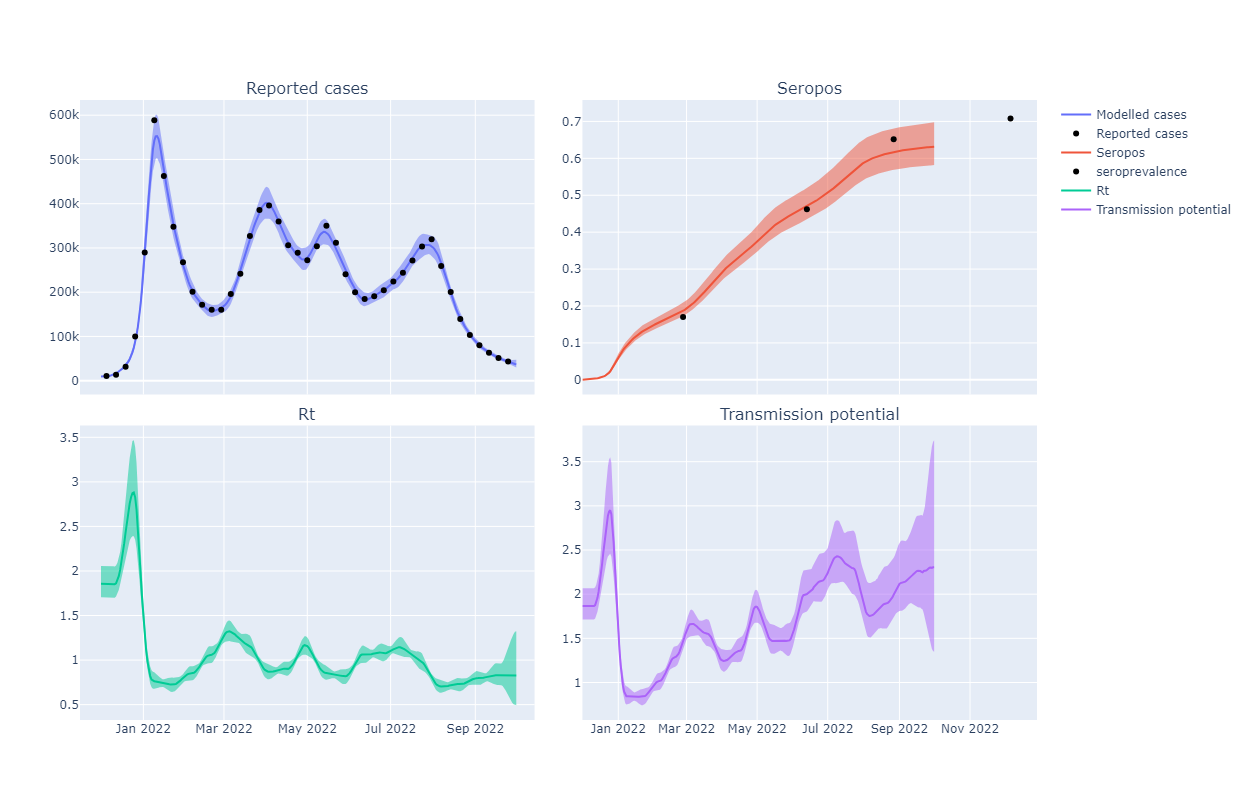

In [62]:
plot_main(quantiles_df, select_data, seroprev_data)

In [51]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
cdr,0.604,0.034,0.539,0.668,0.001,0.001,899.0,744.0,1.0
dispersion_[ 10526. 13403. 31489. 99764. 289614. 588813. 462325. 347960.\n 267817. 201112. 171754. 160429. 160402. 195717. 241848. 327240.\n 385762. 395982. 359765. 306184. 289282. 272054. 304061. 350375.\n 311716. 240429. 199964. 184472. 191043. 204308. 224002.5 243697.\n 271605. 303029. 319779. 259334. 200397. 139178. 103184. 79985.\n 63392. 51273. 43401. ],0.072,0.012,0.051,0.095,0.000,0.000,1026.0,1296.0,1.0
dispersion_[0.17 0.462 0.652],0.097,0.044,0.031,0.181,0.001,0.001,1444.0,1025.0,1.0
gen_mean,6.541,0.495,5.662,7.496,0.015,0.011,1052.0,1239.0,1.0
gen_sd,4.126,0.507,3.258,5.134,0.014,0.010,1256.0,1013.0,1.0
proc[0],0.459,0.120,0.243,0.689,0.003,0.002,1581.0,1209.0,1.0
proc[1],-1.248,0.148,-1.521,-0.970,0.004,0.003,1654.0,1606.0,1.0
proc[2],-0.020,0.124,-0.268,0.189,0.003,0.003,1813.0,1377.0,1.0
proc[3],0.189,0.109,-0.013,0.408,0.003,0.002,1903.0,1188.0,1.0
proc[4],0.246,0.103,0.047,0.429,0.002,0.002,2184.0,1439.0,1.0


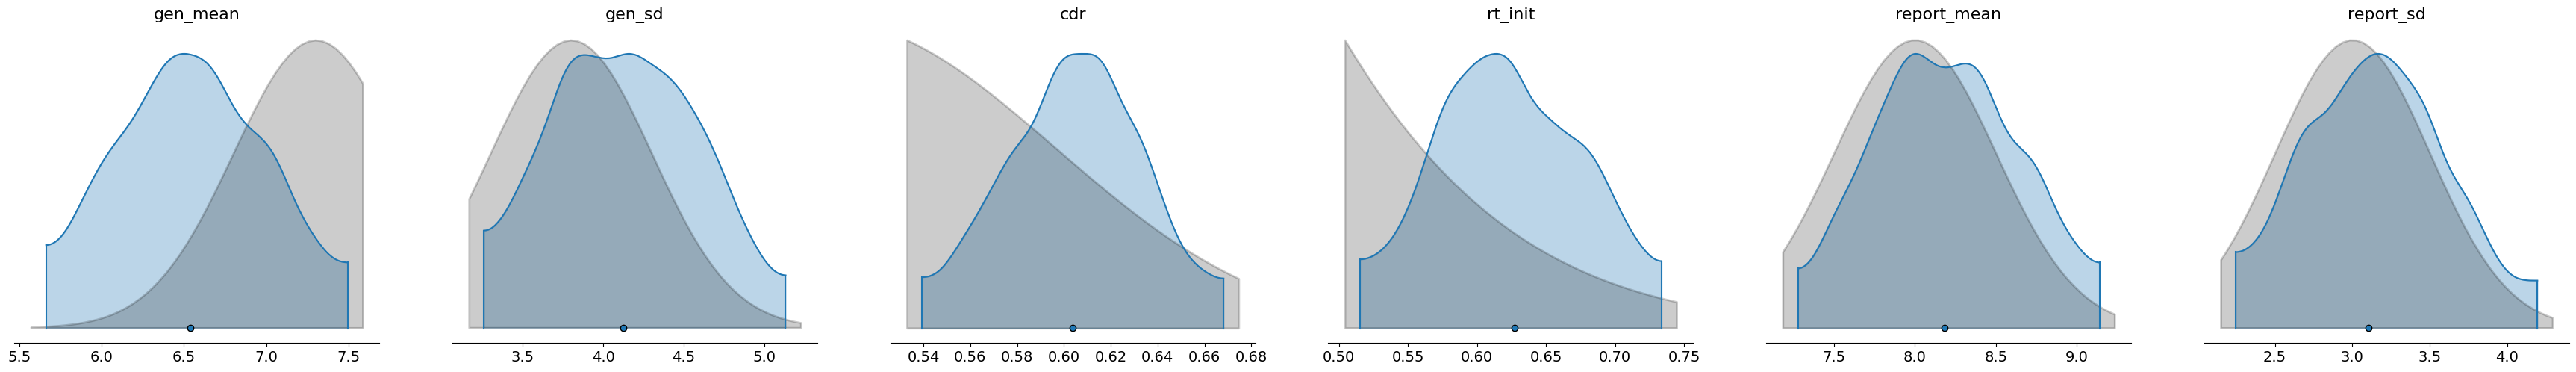

In [15]:
plot_post_prior_comparison(idata, list(priors.keys()), priors);

In [ ]:
quantiles_df

In [ ]:
df_week = quantiles_df['weekly_sum']

In [ ]:
df_week['deaths'] = df_week[0.50]*(0.14/100)

In [ ]:
df_prev = quantiles_df['susceptibles']

In [ ]:
df_prev = (pop - df_prev)/pop

In [ ]:
fig = df_prev.plot()

fig.add_scatter(x=seroprev_data['date'], y=seroprev_data['seroprevalence'])

fig.show()

In [ ]:
# read in seroprev data
seroprev_data = pd.read_csv(DATA_PATH / "aus_seroprev_data.csv")

In [ ]:
seroprev_data

In [ ]:
fig = px.line(df_prev, x=df_prev.index, y=df_prev.columns)

fig.add_scatter(x=seroprev_data['date'], y=seroprev_data['seroprevalence'])

fig.show()